In [1]:
import numpy as np
import os
import scipy 
from sympy import *
import pylab as plt
import math
import matplotlib.image as mpimg
from sympy.physics.wigner import gaunt
from scipy.integrate import odeint
from scipy import integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, spherical_yn
#from pdf2image import convert_from_path
%matplotlib inline

In [2]:
#Universal Constants
h = 6.6260715e-34 #m^2 kg / s
hbar = h/(2*np.pi)
c = 2.99792458e8 #m/s
kb = 1.380649e-23 #Joules per Kelvin

BohrInAng = .529177210544
uBohrInAng = .00000000082

HartreeInEV = 27.211386245981
uHartreeInEV = .00000000030

hcInEVAngstrom = 1973.2698044

In [3]:
def Silvera_Triplet(R):
    x = R * hcInEVAngstrom / 4.16 
    D = 1.28
    K2eV = 8.617333262e-5
    F=(x>D)+(x<D)*np.exp(-(D/x-1)**2)
    return 6.46 * K2eV * (4.889e4*np.exp(0.0968-8.6403*x-2.427*x**2)-(1.365/x**6+0.425/x**8+0.183/x**10)*F)

def Triplet(x): 
    conv = hcInEVAngstrom / BohrInAng
    R = x * conv
    P = np.exp(0.09678-1.10173*R-0.03945*R**2)+np.exp(-(10.04/R-1)**2)*(-6.5/R**6-124/R**8-3285/R**10)
    return P * HartreeInEV

def J(Rho):
    R = Rho * hcInEVAngstrom / BohrInAng
    P = np.exp(-.288-.275*R-.176*R**2+.0068*R**3)
    return P * HartreeInEV

def Singlet(R):
    return Silvera_Triplet(R) - J(R)

In [4]:
data = np.genfromtxt('./shortrangesinglet.csv', delimiter=',', skip_header=1)
data2 = np.genfromtxt('./NewerKolos.csv', delimiter=',', skip_header=1)

interp_func = interp1d(data[:,0], data[:,1], kind = 'cubic',fill_value='extrapolate')
interp_funcnew = interp1d(data2[:,0], -data2[:,1], kind = 'cubic',fill_value='extrapolate')

ranges = data[:,0]
singlet_data = data[:,1]

def singlet(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    return (interp_func(Rp) + 1) * HartreeInEV

new_ranges = np.linspace(.45, 10, 100) / hcInEVAngstrom

def singletnew(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    return (interp_funcnew(Rp) + 1) * HartreeInEV

def singletcombo(rho):
    Rp = rho / BohrInAng * hcInEVAngstrom
    split1_2=6.3 # Make the split within the range where function has support (between last 2 bins)
    split2_3=11.5 #  [As above]
    Decide1=(Rp<split1_2)
    Decide2=(Rp>=split1_2)*(Rp<split2_3)
    Decide3=(Rp>=split2_3)

    #return (Decide1*(interp_func(R * 1973) + 1)  + Decide2*(interp_funcnew(R * 1973) + 1) + Decide3*(interp_funcnew(10) + 1)*(R*1973.27/10)**-6) * 27.2114

    return (Decide1*(interp_func(Rp) + 1)  + Decide2*(interp_funcnew(Rp) + 1) + Decide3*(interp_funcnew(split2_3) + 1)*(Rp/split2_3)**-6) * HartreeInEV

In [5]:
def p_of_temp(mu, T):
    J2eV = 6.241508074e18
    return np.sqrt(2 * mu * kb * J2eV * T)
 
def pprime(pin, epsa, epsb, epsprimea, epsprimeb, mu):
    E = pin**2 / (2 * mu)
    Eprime = E + epsa + epsb - epsprimea - epsprimeb
    pprime = np.sqrt(2 * mu * Eprime)
    return pprime

def p_abs(mu, pin, epsa, epsb, epsprimea, epsprimeb):
    psquared = pin**2 + mu * (epsa + epsb - epsprimea - epsprimeb)
    return np.sqrt(psquared)

In [6]:
def ddx(y, rho, mu, Potential, l, pin):
    u = y[0]
    v = y[1]
    dudr = v
    dvdr = (-pin**2 + 2 * mu * Potential(rho) + l * (l + 1) / (rho**2)) * u
    return [dudr,dvdr]
    
def Wave_Function(pin, l, bigrho, r0, function, mass, version, int_type):
    rhos = np.linspace(r0, bigrho, 20000)
    init = [r0,1]
    def ddxToint(rhos, y):
        return function(y, rhos, mass, version, l, pin)
    State = scipy.integrate.solve_ivp(ddxToint, (rhos[0] ,rhos[-1]), init, t_eval=rhos, method = int_type)
    Normalization = np.sqrt(State.y[0]**2 + (State.y[1]/pin)**2) 
    return State.y[0]/Normalization[-1]

def GetIntegral (alphain, betain, alphaout, betaout, mass, A, r0, temp, version, how_to_int):
    rhos = np.linspace(r0, A, 20000)

    P1 = p_of_temp(mass, temp)
    P2 = pprime(P1, alphain, betain, alphaout, betaout, mass)
    
    InState = np.array(Wave_Function(P1, 0, A, r0, ddx, mass, version, how_to_int))
    OutState = np.array(Wave_Function(P2, 2, A, r0, ddx, mass, version, how_to_int))

    Integrand = interp1d(rhos, InState * OutState / rhos**3, kind = 'quadratic')
    
    Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)

    return Integral

def GetSpatialsDip (mu, Temps, levels, version):
    aaSpatials = []
    acSpatials = []
    adSpatials = []
    ccSpatials = []
    cdSpatials = []
    
    for t in Temps:
        a = levels['a'][0]
        c = levels['c'][0]
        d = levels['d'][0]

        r0 = 1e-9
        intlimit = .75

        Pin = p_of_temp(mu, t)
        Paa_out = pprime(Pin, d, d, a, a, mu)
        Pac_out = pprime(Pin, d, d, a, c, mu)
        Pad_out = pprime(Pin, d, d, a, d, mu)
        Pcc_out = pprime(Pin, d, d, c, c, mu)
        Pcd_out = pprime(Pin, d, d, c, d, mu)
        
        aaIntegral = GetIntegral(d, d, a, a, mu, intlimit, r0, t, version, 'Radau')
        acIntegral = GetIntegral(d, d, a, c, mu, intlimit, r0, t, version, 'Radau')
        adIntegral = GetIntegral(d, d, a, d, mu, intlimit, r0, t, version, 'Radau')
        ccIntegral = GetIntegral(d, d, c, c, mu, intlimit, r0, t, version, 'Radau')
        cdIntegral = GetIntegral(d, d, c, d, mu, intlimit, r0, t, version, 'Radau')

        aaSpatials.append(Paa_out * mu**2 * aaIntegral**2 / Pin)
        acSpatials.append(Pac_out * mu**2 * acIntegral**2 / Pin)
        adSpatials.append(Pad_out * mu**2 * adIntegral**2 / Pin)
        ccSpatials.append(Pcc_out * mu**2 * ccIntegral**2 / Pin)
        cdSpatials.append(Pcd_out * mu**2 * cdIntegral**2 / Pin)

    aaSpatials = np.array(aaSpatials)
    acSpatials = np.array(acSpatials)
    adSpatials = np.array(adSpatials)
    ccSpatials = np.array(ccSpatials)
    cdSpatials = np.array(cdSpatials)

    return (aaSpatials, acSpatials, adSpatials, ccSpatials, cdSpatials)

In [7]:
B_Values = np.logspace(-3,1,50)

In [8]:
def GetHyperFineLevels(pm, mf, delW, mN, gI):
    gL = 1 #Orbital g-factor
    gS = 2 #Electron spin g-factor
    L = 0 #Orbital Angular Momentum
    S = .5 #Electron spin
    I = .5 #Nuclear spin
    J = .5 #Total Angular Momentum
    ge = 2.002319 #Electron g-factor
    meeV = .511e6 #mass of electron
    mue = 9.27e-24 #magnetic moment of electron
    muN = mue*meeV/(mN*1e9) #magnetic moment of nucleus
    J2eV = 6.242e18
    
    gJ = gL * (J * (J + 1) + L * (L + 1) - S * (S + 1)) / (2 * J * (J + 1)) + ge * (J * (J + 1) - L * (L +1) + S * (S + 1)) / (2 * J *(J + 1))

    x = B_Values * (gJ * mue - gI * muN) / (h * delW)
    Term1 = -h * delW / (2 * (2 * I + 1)) * np.ones_like(B_Values)
    Term2 = muN * gI * mf * B_Values

    if(abs(mf)==abs(I + .5)):
        sgn = mf / (I + .5)
        Term3 = h*delW / 2 * (1 + sgn*x)
    else:
        Term3 = pm * h * delW / 2 * np.sqrt(1 + 2 * mf * x / (I + .5) + x**2)

    delE = (Term1 + Term2 + Term3) / h

    return delE * h * J2eV

def AllHFLevels(delW, mN, gI): 
    delEs = []
    for pm in [-1,1]:
        F = .5 + pm/2
        for mF in np.arange(-F, F+1, 1):
            delEs.append(GetHyperFineLevels(pm, mF, delW, mN, gI))
    delEs = np.array(delEs)
    delEs = np.sort(delEs, axis = 0)
    delEDict={}
    for i in range(0,4):
        letter = chr(97 + i)
        delEDict[letter]=delEs[i]
    return delEDict

In [9]:
delWH = 1.4204057517667e9 #Hyperfine of hydrogen splitting constant in Hz
delWT = 1.516701396e9
gIH = 5.585694702 # Hydrogen nuclear g-factor
gIT = 5.95792492 
mH = 1.00784 #Mass of hydrogen in Dalton
mT = 3.01604928 

HLevels = AllHFLevels(delWH, mH, gIH)
TLevels = AllHFLevels(delWT, mT, gIT)

In [10]:
e=symbols('e')
c=symbols('c')
s=symbols('s')
sr2=symbols('sr2')
sr3=symbols('sr3')

In [11]:
def LetterToNumber(letter):
    if(letter=="a"):
        return 0
    elif(letter=="b"):
        return 1
    elif(letter=="c"):
        return 2
    elif(letter=="d"):
        return 3
    else:
        print("invalid letter state, "+str(letter))
        assert(0)

In [12]:
def NumberToLetter(num):
    if(num==0):
        return "a"
    elif(num==1):
        return "b"
    elif(num==2):
        return "c"
    elif(num==3):
        return "d"
    else:
        print("invalid number state, "+str(num))
        assert(0)

In [13]:
def StateToBasis(in1,in2,p=1):
    # convert letter basis to number basis
    if(type(in1)==str):
        in1=LetterToNumber(in1)
    else:
        in1=int(in1)
    if(type(in2)==str):
        in2=LetterToNumber(in2)
    else:
        in2=int(in2)
    #swap so first one is always smaller
    if(in2<in1):
        in1old=in1
        in1=in2
        in2=in1old

    if(in1==0 and in2==0 and p==1):
        return 0
    if(in1==1 and in2==1 and p==1):
        return 1
    if(in1==2 and in2==2 and p==1):
        return 2
    if(in1==3 and in2==3 and p==1):
        return 3
    if(in1==0 and in2==1 and p==1):
        return 4
    if(in1==0 and in2==1 and p==-1):
        return 5
    if(in1==0 and in2==2 and p==1):
        return 6
    if(in1==0 and in2==2 and p==-1):
        return 7
    if(in1==0 and in2==3 and p==1):
        return 8
    if(in1==0 and in2==3 and p==-1):
        return 9
    if(in1==1 and in2==2 and p==1):
        return 10
    if(in1==1 and in2==2 and p==-1):
        return 11
    if(in1==1 and in2==3 and p==1):
        return 12
    if(in1==1 and in2==3 and p==-1):
        return 13
    if(in1==2 and in2==3 and p==1):
        return 14
    if(in1==2 and in2==3 and p==-1):
        return 15

In [14]:
SingletProj=[
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1/2,0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1/2,0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ]

TripletProj=[
    [1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, 0.5,0.5, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1]
                ]


Sig2m2proj=-1/2*np.array([
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])


Sig2p2proj=-1/2*np.array([
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])
#sr2=np.sqrt(2)
Sig2p1proj=-1/2*np.array([
    [0,  0,  0,  0,  0,  0,  0,  0, -1/sr2,0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,-1/sr2, 0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, -1/2,  0,  0,  0,  0,  0, -1/2,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, -1/2,  0,  0,  0,  0,  0, -1/2,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 1/2, 0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,1/2],
    [0,  0,  0,1/(2*sr2),0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,1/(2*sr2),0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 1/2, 0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,1/2],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])

Sig2m1proj=1/2*np.array([
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 1/sr2, 0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,1/sr2, 0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,-1/2, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,-1/2, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [-1/(2*sr2), 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,-1/(2*sr2),  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0, 1/2, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0, 1/2, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 1/2,  0,  0,  0,  0,  0,  1/2,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, 1/2,  0,  0,  0,  0,  0,  1/2,  0,  0]
                ])

Sig20proj=-np.sqrt(3/2)*np.array([
    [1/6,0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,1/6,  0,  0,  0,  0,  0,1/6,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,1/6,  0,  0,  0,  0,  0,1/6,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,-1/3, 0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,-1/3, 0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 1/6, 0,  0,  0,  0,  0, 1/6, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, 1/6, 0,  0,  0,  0,  0, 1/6, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 1/6, 0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,1/6]
                ])

In [15]:
Rotator=[
    [1,  0,  0,  0,  0,  0, 2*e, 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0, -2*e,0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  e,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, -e,  0,  0,  0,  0],
    [-e, 0,  e,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0, -e,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  e,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  -e, 0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  -e, 0,  0,  0,  0,  1]
                ]

    # aa      bb    cc  dd     ab ab  ac     ac  ad  ad  bc  bc  bd  bd  cd  cd 
Rotator=np.array([
    [c*c,     0,    s*s,0,     0,  0,sr2*s*c, 0,  0,  0,  0,  0,  0,  0,  0,  0],   #aa
    [0,       1,    0,  0,     0,  0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0],   #bb
    [s*s,     0,    c*c,0,     0,  0,-sr2*s*c,0,  0,  0,  0,  0,  0,  0,  0,  0],   #cc
    [0,       0,    0,  1,     0,  0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0],   #dd
    [0,       0,    0,  0,     c,  0,  0,     0,  0,  0,  s,  0,  0,  0,  0,  0],   #ab
    [0,       0,    0,  0,     0,  c,  0,     0,  0,  0,  0,  s,  0,  0,  0,  0],   #ab
    [-sr2*s*c,0,sr2*s*c,0,     0,  0, c*c-s*s,0,  0,  0,  0,  0,  0,  0,  0,  0],   #ac  
    [0,       0,    0,  0,     0,  0,  0,     1,  0,  0,  0,  0,  0,  0,  0,  0],   #ac
    [0,       0,    0,  0,     0,  0,  0,     0,  c,  0,  0,  0,  0,  0,  s,  0],   #ad
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  c,  0,  0,  0,  0,  0,  s],   #ad
    [0,       0,    0,  0,    -s,  0,  0,     0,  0,  0,  c,  0,  0,  0,  0,  0],   #bc
    [0,       0,    0,  0,     0,  -s, 0,     0,  0,  0,  0,  c,  0,  0,  0,  0],   #bc
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  0,  0,  0,  1,  0,  0,  0],   #bd
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  0,  0,  0,  0,  1,  0,  0],   #bd
    [0,       0,    0,  0,     0,  0,  0,     0,  -s, 0,  0,  0,  0,  0,  c,  0],   #cd
    [0,       0,    0,  0,     0,  0,  0,     0,  0,  -s, 0,  0,  0,  0,  0,  c]    #cd
                ])

Sigmas={-2:Sig2m2proj,-1:Sig2m1proj,0:Sig20proj,1:Sig2p1proj,2:Sig2p2proj}

In [16]:
def TransformMatrix(M,R):
    return(np.matmul(np.transpose(R),np.matmul(M,R)))

def RotateByEpsilon(M,eps):
    M1=TransformMatrix(M,Rotator)
    return(EvaluateWithEpsilon(M,eps))

def EvaluateWithEpsilon(M,eps):
    return np.array([(i+0*e).subs(e,eps) for i in M.flatten()]).reshape(M.shape).astype(float)

In [17]:
def GetElement(M,alpha, beta, p1, alphaprime, betaprime, pprime):
    index1=StateToBasis(alpha,beta,p1)
    index2=StateToBasis(alphaprime,betaprime,pprime)
    return(M[index1,index2])

In [18]:
Rets={}
for m in Sigmas.keys():
    SigMatrix=Sigmas[m]
    Rets[m]=TransformMatrix(np.matmul(np.matmul(TripletProj,SigMatrix),TripletProj),Rotator)

In [19]:
def Theta(a,B,gamN):
    game=-28024.9*1e6 # In Hz T^-1
    return(0.5*np.arctan(a/(2*B*(game+gamN))))

def GetSpinsDip(delW, B, gam):
    NormDiff = 4*np.sqrt(6)
    letters = ['a', 'c', 'd']
    a1 = 'd'
    a2 = 'd' 

    aaSpins = []
    acSpins = []
    adSpins = []
    ccSpins = []
    cdSpins = []

    for a3 in letters:
        for a4 in letters:
            line = []
            for b in B:
                theta = Theta(delW, b, gam)
                value = 0 
                for m in Rets.keys():
                    El = ( GetElement(Rets[m], a1, a2, 1, a3, a4, 1)) **2
                    try: 
                        value += El.subs(sr2, np.sqrt(2)) \
                                .subs(sr3, np.sqrt(3)) \
                                .subs(c, np.cos(theta)) \
                                .subs(s, np.sin(theta))
                    except:
                        value += 0
                line.append(value)
            if a3 == 'a' and a4 == 'a':
                aaSpins = line  
            elif a3 == 'a' and a4 == 'c':
                acSpins = line
            elif a3 == 'a'  and a4 == 'd':
                adSpins = line
            elif a3 == 'c' and a4 == 'c':
                ccSpins = line
            elif a3 == 'c' and a4 == 'd':
                cdSpins = line

    aaSpins = np.array(aaSpins)*NormDiff**2
    acSpins = np.array(acSpins)*NormDiff**2
    adSpins = np.array(adSpins)*NormDiff**2
    ccSpins = np.array(ccSpins)*NormDiff**2
    cdSpins = np.array(cdSpins)*NormDiff**2

    return(aaSpins, acSpins, adSpins, ccSpins, cdSpins)    

In [20]:
Temp_Values = np.logspace(-3,2,50)

In [21]:
Hm = 938.78e6 #Mass of hydrogen in eV/c^2
Tm = 2808.9261e6
Hmu = Hm/2
Tmu = Tm/2

HSpatials = GetSpatialsDip(Hmu, Temp_Values, HLevels, Silvera_Triplet)
TSpatials = GetSpatialsDip(Tmu, Temp_Values, HLevels, Silvera_Triplet)

delWH = 1.4204057517667e9 #Hyperfine of hydrogen splitting constant in Hz
delWT = 1.516701396e9
#gyromagnetic constants 
gamH=42.577*1e6 # In Hz T^-1
gamT=45.415*1e6 # In Hz T^-1

HSpins = GetSpinsDip(delWH, B_Values, gamH)
TSpins = GetSpinsDip(delWT, B_Values, gamT)

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_8460/1892420344.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_8460/1892420344.py:28: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)


In [22]:
Conversion = ((1.973269804e-5)/(5.29177210544e-9))**2
me = .511e6
alpha = 1/137
mue = np.sqrt(4 * np.pi * alpha) / (2 * me)
Pre_Factor  = 1/(5*np.pi) * mue**4

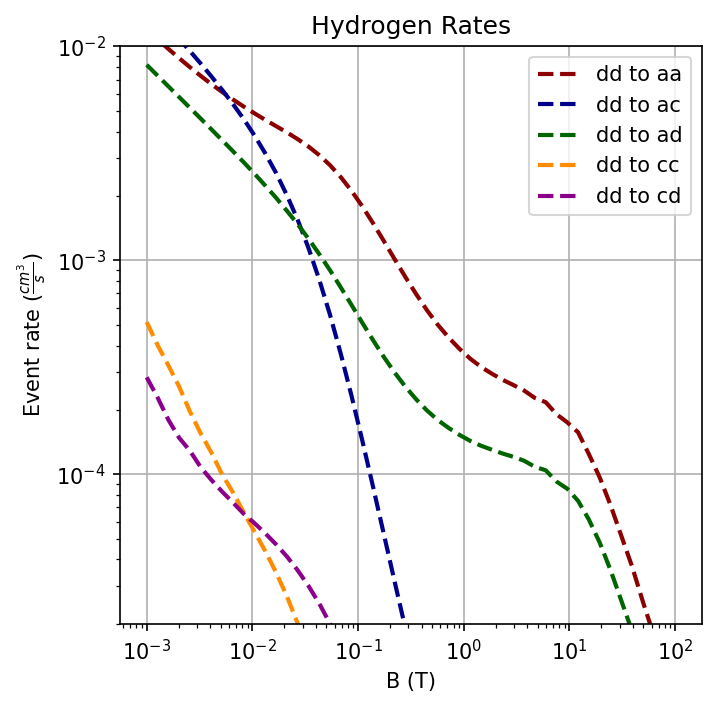

In [23]:
plt.figure(figsize=(5, 5), dpi = 150)
plt.plot(Temp_Values, Conversion * Pre_Factor * HSpatials[0] * HSpins[0], '--', label="dd to aa", color = "DarkRed", linewidth=2)
plt.plot(Temp_Values, Conversion * Pre_Factor * HSpatials[1] * HSpins[1], '--', label="dd to ac", color = "DarkBlue", linewidth=2)
plt.plot(Temp_Values, Conversion * Pre_Factor * HSpatials[2] * HSpins[2], '--', label="dd to ad", color = "DarkGreen",linewidth=2)
plt.plot(Temp_Values, Conversion * Pre_Factor * HSpatials[3] * HSpins[3], '--', label="dd to cc", color = "DarkOrange", linewidth=2)
plt.plot(Temp_Values, Conversion * Pre_Factor * HSpatials[4] * HSpins[4], '--', label="dd to cd", color = "DarkMagenta", linewidth=2)
plt.xlabel("B (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(2e-5,.01)
plt.title("Hydrogen Rates")
plt.grid(True)
plt.legend()
plt.loglog()
plt.show()

(-4.698970004336019, -2.0)

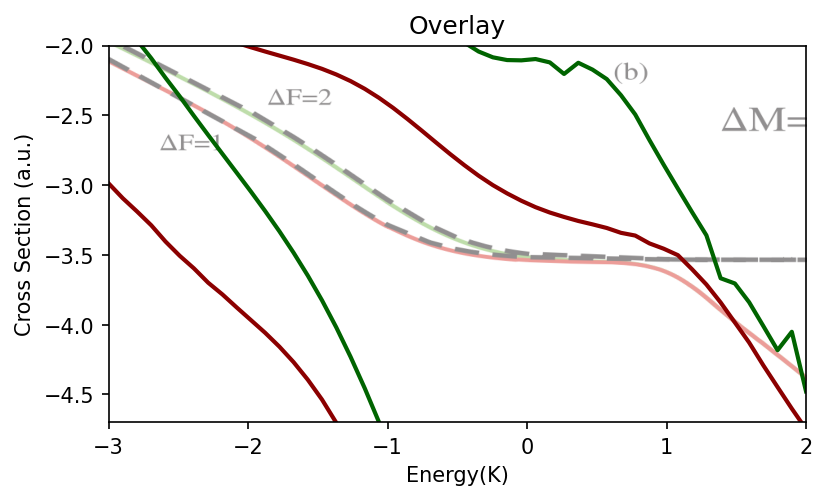

In [24]:
image = mpimg.imread("./ZYG1.b.png")


x_min, x_max = .001, 100
y_min, y_max = 2e-5, .01

log_x_min, log_x_max = np.log10(x_min), np.log10(x_max)
log_y_min, log_y_max = np.log10(y_min), np.log10(y_max)

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

ax.imshow(image, extent=[log_x_min, log_x_max, log_y_min, log_y_max], alpha=0.5)

Temp_array = np.array(Temp_Values, dtype=float)
Temp_log = np.log10(Temp_array)

Haa_array = np.array(Conversion * Pre_Factor * HSpatials[0] * HSpins[0] * 2, dtype=float)
Taa_array = np.array(Conversion * Pre_Factor * TSpatials[0] * TSpins[0] * np.sqrt(Tmu/Hmu)*2, dtype=float)
Hcc_array = np.array(Conversion * Pre_Factor * HSpatials[3] * HSpins[3] * 2, dtype=float)
Tcc_array = np.array(Conversion * Pre_Factor * TSpatials[3] * TSpins[3] * np.sqrt(Tmu/Hmu)*2, dtype=float)

Haa_log = np.log10(Haa_array)
Taa_log = np.log10(Taa_array)
Hcc_log = np.log10(Hcc_array)
Tcc_log = np.log10(Tcc_array)

ax.plot(Temp_log, Haa_log, label="H-H", color="DarkRed", linewidth=2)
ax.plot(Temp_log, Taa_log, label="T-T", color="DarkGreen", linewidth=2)
ax.plot(Temp_log, Hcc_log, label="H-H", color="DarkRed", linewidth=2)
ax.plot(Temp_log, Tcc_log, label="T-T", color="DarkGreen", linewidth=2)

ax.set_xlabel("Energy(K)")
ax.set_ylabel("Cross Section (a.u.)")
ax.set_title("Overlay")

ax.set_xlim(log_x_min, log_x_max)
ax.set_ylim(log_y_min, log_y_max)

In [40]:
def Wave_Function(pin, l, bigrho, r0, function, mass, version, int_type):
    rhos = np.linspace(r0, bigrho, 100)
    init = [r0,1]
    def ddxToint(rhos, y):
        return function(y, rhos, mass, version, l, pin)
    State = scipy.integrate.solve_ivp(ddxToint, (rhos[0], rhos[-1]), init, t_eval=rhos, method = int_type)
    Normalization = np.sqrt(State.y[0]**2 + (State.y[1]/pin)**2)
    return (np.sqrt(2/np.pi)*State.y[0]/Normalization[-1],np.sqrt(2/np.pi)*State.y[1]/Normalization[-1])
    
def GetPhaseShift(bigrho, p, l, r0, mass, version, how_to_int):
    rhos = np.linspace(r0, bigrho, 100)
    init = [r0,1]
    
    State = np.array(Wave_Function(p, l, bigrho, r0, ddx, mass, version, how_to_int)[0])
    Statedev = np.array(Wave_Function(p, l, bigrho, r0, ddx, mass, version, how_to_int)[1])

    Big = Big_delta_l = (rhos * Statedev - State) / (rhos * State)
    jl_ka = spherical_jn(l, p * rhos)
    jl_prime_ka = spherical_jn(l, p * rhos, derivative=True)
    nl_ka = spherical_yn(l, p * rhos)
    nl_prime_ka = spherical_yn(l, p * rhos, derivative=True)

    #deltas = np.arctan((p*jl_prime_ka - Big_delta_l*jl_ka) / (p*nl_prime_ka - Big_delta_l * nl_ka)) 
    deltas=np.arctan(p*State/Statedev)-p*rhos
    return deltas[-1]

def GetSpatialsEx(mu, temps, levels, version_one, version_two):
    aaSpatials = []
    acSpatials = []
    bdSpatials = []
    for t in temps:
        a = levels['a'][0]
        b = levels['b'][0]
        c = levels['c'][0]
        d = levels['d'][0]

        r0 = 1e-9
        intlimit = 10 * BohrInAng/hcInEVAngstrom
        
        Pin = p_of_temp(mu, t)
        Paa = pprime(Pin, c, c, a, a, mu)
        Pac = pprime(Pin, c, c, c, a, mu)
        Pbd = pprime(Pin, c, c, b, d, mu)
        Pabsaa = p_abs(mu, Pin, c, c, a, a)
        Pabsac = p_abs(mu, Pin, c, c, a, c)
        Pabsbd = p_abs(mu, Pin, c, c, b, d)

        const =  np.pi / (Pin)
        
        tdeltaaa = GetPhaseShift(intlimit*10, Pabsaa, 0, r0, mu, version_one, 'Radau')
        tdeltaac = GetPhaseShift(intlimit*10, Pabsac, 0, r0, mu, version_one, 'Radau')
        tdeltabd = GetPhaseShift(intlimit*10, Pabsbd, 0, r0, mu, version_one, 'Radau')

        sdeltaaa = GetPhaseShift(intlimit*10, Pabsaa, 0, r0, mu, version_two, 'Radau')
        sdeltaac = GetPhaseShift(intlimit*10, Pabsac, 0, r0, mu, version_two, 'Radau')
        sdeltabd = GetPhaseShift(intlimit*10, Pabsbd, 0, r0, mu, version_two, 'Radau')

        aaSpatials.append(((1.973269804e-5)/(5.29177210544e-9))**2 * const * (Paa / Pabsaa**2) * (np.sin(tdeltaaa - sdeltaaa)**2))
        acSpatials.append(((1.973269804e-5)/(5.29177210544e-9))**2 * const * (Pac / Pabsac**2) * (np.sin(tdeltaac - sdeltaac)**2))
        bdSpatials.append(((1.973269804e-5)/(5.29177210544e-9))**2 * const * (Pbd / Pabsbd**2) * (np.sin(tdeltabd - sdeltabd)**2))

    aaSpatials = np.array(aaSpatials)
    acSpatials = np.array(acSpatials)	
    bdSpatials = np.array(bdSpatials)

    return(aaSpatials, acSpatials, bdSpatials)

In [41]:
def GetHyperFineLevels(pm, mf, delW, mN, gI, ge, meeV, mue):
    gL = 1 #Orbital g-factor
    gS = 2 #Electron spin g-factor
    L = 0 #Orbital Angular Momentum
    S = .5 #Electron spin
    I = .5 #Nuclear spin
    J = .5 #Total Angular Momentum
    muN = mue*meeV/(mN*1e9) #magnetic moment of nucleus
    J2eV = 6.241509074e18
    
    gJ = gL * (J * (J + 1) + L * (L + 1) - S * (S + 1)) / (2 * J * (J + 1)) + ge * (J * (J + 1) - L * (L +1) + S * (S + 1)) / (2 * J *(J + 1))

    x = B_Values * (gJ * mue - gI * muN) / (h * delW)
    Term1 = -h * delW / (2 * (2 * I + 1)) * np.ones_like(B_Values)
    Term2 = muN * gI * mf * B_Values

    if(abs(mf)==abs(I + .5)):
        sgn = mf / (I + .5)
        Term3 = h*delW / 2 * (1 + sgn*x)
    else:
        Term3 = pm * h * delW / 2 * np.sqrt(1 + 2 * mf * x / (I + .5) + x**2)

    delE = (Term1 + Term2 + Term3) / h

    return delE * h * J2eV

def AllHFLevels(delW, mN, gI, ge, meeV, mue): 
    delEs = []
    for pm in [-1,1]:
        F = .5 + pm/2
        for mF in np.arange(-F, F+1, 1):
            delEs.append(GetHyperFineLevels(pm, mF, delW, mN, gI, ge, meeV, mue))
    delEs = np.array(delEs)
    delEs = np.sort(delEs, axis = 0)
    delEDict={}
    for i in range(0,4):
        letter = chr(97 + i)
        delEDict[letter]=delEs[i]
    return delEDict

In [42]:
delWH = 1.4204057517667e9 #Hyperfine of hydrogen splitting constant in Hz
delWT = 1.516701470775e9

gIH = 5.585694706 # Hydrogen nuclear g-factor
gIT = 5.957924930 
mH = 1.00727646657894 #Mass of hydrogen in Dalton
mT = 3.01550071597 

ge = 2.00231930436092
meeV = .51099895069e6
mue = 9.2847646917e-24

HLevels = AllHFLevels(delWH, mH, gIH, ge, meeV, mue)
TLevels = AllHFLevels(delWT, mT, gIT, ge, meeV, mue)

meeV = .51099895069e6
Hm = 938.27208942e6 + meeV #Mass of hydrogen in eV/c^2
Tm = 2808.92113668e6 + meeV
Hmu = Hm/2
Tmu = Tm/2

gamH=42.56385437*1e6 # In Hz T^-1
gamT=45.41483817*1e6 # In Hz T^-1

muN = 5.0507837393e-27
mue = 9.2847646917e-24
ge = 2.0023193043609

magH = gIH * muN  
magT = gIT * muN   
mage = ge * mue  

hbar =6.62607015e-34
aH= delWH * hbar
aT= delWT * hbar

def Theta(a, B, magN):
    muplus=mage + magN  
    return (0.5*np.arctan(a / (B * muplus))) 

aH= delWH * hbar
aT= delWT * hbar

In [43]:
SingletProj=np.array([
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  1/2,0,  0,  0,  0,  0, -1/2,0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1/2,0,  0,  0,  0,  0, -1/2,0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])

TripletProj=np.array([
    [1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0.5,0,  0,  0,  0,  0, 0.5, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0.5,0,  0,  0,  0,  0,  0.5,0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1]
                ])

In [44]:
def GetspinEx(a, B_values, magN, a3, a4):
    line = []
    for Bs in B_values:
        th = Theta(a, Bs,magN )
        
        SpinPart = TransformMatrix(TripletProj-SingletProj,Rotator)

        El=(GetElement(SpinPart,"c","c",1,a3,a4,1))**2
        Value=El.subs(sr2,np.sqrt(2)).subs(sr3,np.sqrt(3)).subs(c,np.cos(th)).subs(s,np.sin(th))

        line.append(Value)
    line = np.array(line)
    return line

In [45]:
HSpinaa = GetspinEx(aH, B_Values, magH, 'a', 'a')[0]
HSpinac = GetspinEx(aH, B_Values, magH, 'a', 'c')[0]
HSpinbd = GetspinEx(aH, B_Values, magH, 'b', 'd')[0]
TSpinaa = GetspinEx(aT, B_Values, magT, 'a', 'a')[0]
TSpinac = GetspinEx(aT, B_Values, magT, 'a', 'c')[0]
TSpinbd = GetspinEx(aT, B_Values, magT, 'b', 'd')[0]

In [46]:
HSpatials = GetSpatialsEx(Hmu, Temp_Values, HLevels, Silvera_Triplet, singletcombo)
TSpatials = GetSpatialsEx(Tmu, Temp_Values, TLevels, Silvera_Triplet, singletcombo)

(-0.6989700043360187, 4.0)

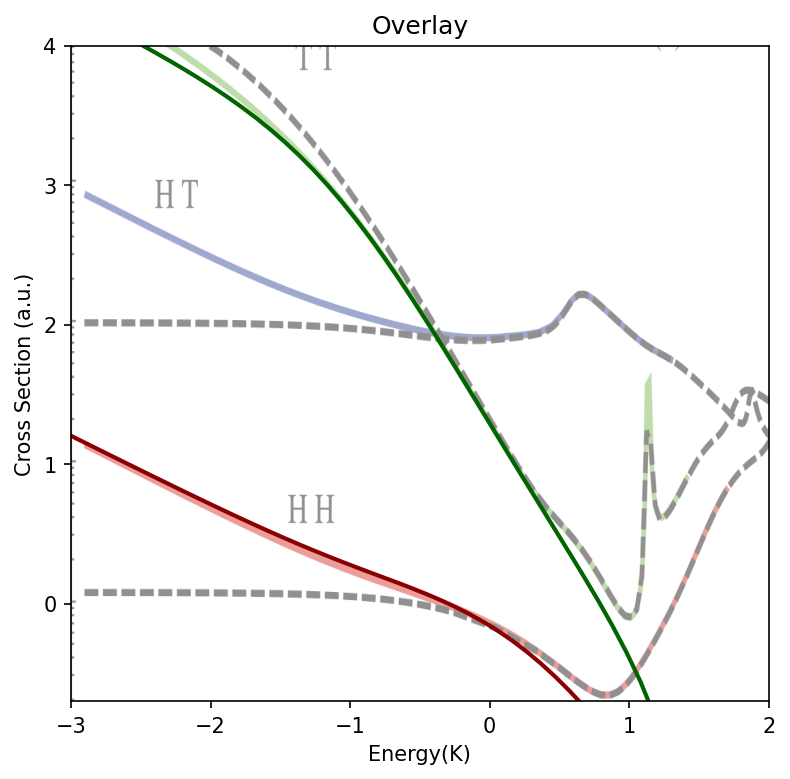

In [47]:
image = mpimg.imread("./ZYG4.a.png")


x_min, x_max = .001, 100
y_min, y_max = .2, 10000

log_x_min, log_x_max = np.log10(x_min), np.log10(x_max)
log_y_min, log_y_max = np.log10(y_min), np.log10(y_max)

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

ax.imshow(image, extent=[log_x_min, log_x_max, log_y_min, log_y_max], alpha=0.5)

Temp_array = np.array(Temp_Values, dtype=float)
Temp_log = np.log10(Temp_array)

Haa_array = np.array(HSpatials[0] * HSpinaa*2, dtype=float)
Taa_array = np.array(TSpatials[0] * TSpinaa * np.sqrt(Tmu/Hmu)*2, dtype=float)

Haa_log = np.log10(Haa_array)
Taa_log = np.log10(Taa_array)

ax.plot(Temp_log, Haa_log, label="H-H", color="DarkRed", linewidth=2)
ax.plot(Temp_log, Taa_log, label="T-T", color="DarkGreen", linewidth=2)

ax.set_xlabel("Energy(K)")
ax.set_ylabel("Cross Section (a.u.)")
ax.set_title("Overlay")

ax.set_xlim(log_x_min, log_x_max)
ax.set_ylim(log_y_min, log_y_max)